In [14]:
from lips import get_root_path
from lips.dataset import airfransDataSet
from lips.dataset.airfransDataSet import AirfRANSDataSet
from lips.benchmark.airfransBenchmark import AirfRANSBenchmark
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

from torch import nn

from airfrans.simulation import Simulation
import pyvista as pv

import xgboost as xgb
import pickle

import os
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

import torch

In [15]:
# indicate required paths
LIPS_PATH = get_root_path()
DIRECTORY_NAME = '../../Airfrans/Dataset'
BENCHMARK_NAME = "Case1"
LOG_PATH = LIPS_PATH + "lips_logs.log"
BENCH_CONFIG_PATH = os.path.join("../../Kit", "airfoilConfigurations","benchmarks","confAirfoil.ini") #Configuration file related to the benchmark
SIM_CONFIG_PATH = os.path.join("../../Kit", "airfoilConfigurations","simulators","torch_fc.ini") #Configuration file re
# print(BENCH_CONFIG_PATH)

# Scalers
PRESS_SCALE = 1600.0
TURB_SCALE = 0.01
SPEED_SCALE = 75.0
DEFAULT_SCALE = 1.0


In [16]:
benchmark=AirfRANSBenchmark(benchmark_path = DIRECTORY_NAME,
                            config_path = BENCH_CONFIG_PATH,
                            benchmark_name = BENCHMARK_NAME,
                            log_path = LOG_PATH)
benchmark.load(path=DIRECTORY_NAME)

Loading dataset (task: reynolds, split: test): 100%|██████████| 496/496 [01:10<00:00,  7.07it/s]


In [17]:
# Create normalizing constants
MEANS = {}
STDS = {}

for var in ['x-position', 'y-position', 'x-inlet_velocity', 'x-velocity', 'pressure', 'turbulent_viscosity']:
    MEANS[var] = np.mean(benchmark.train_dataset.data[var])
    STDS[var] = np.std(benchmark.train_dataset.data[var])

MEANS['speed'] = MEANS['x-inlet_velocity']
STDS['speed'] = STDS['x-inlet_velocity']
MEANS['position'] = 0.0
STDS['position'] = 1.0

for var in ['x-position', 'y-position', 'x-inlet_velocity', 'x-velocity']:
    MEANS.pop(var, None)
    STDS.pop(var, None)

print(MEANS)
print(STDS)

x_means = np.zeros(2, dtype=np.float32)
x_stds = np.zeros(2, dtype=np.float32)
y_means = np.zeros(4, dtype=np.float32)
y_stds = np.zeros(4, dtype=np.float32)

for i, var in zip(range(2), ['position', 'speed']):        
    x_means[i] = MEANS[var]
    x_stds[i] = STDS[var]

for i, var in zip(range(4), ['position', 'speed', 'pressure', 'turbulent_viscosity']):        
    y_means[i] = MEANS[var]
    y_stds[i] = STDS[var]

MEANS['pressure'] = 0.0
MEANS['turbulent_viscosity'] = 0.0


{'pressure': -395.22959540860137, 'turbulent_viscosity': 0.0008392954292084482, 'speed': 63.15423170302567, 'position': 0.0}
{'pressure': 2425.738434726353, 'turbulent_viscosity': 0.0030420989011928183, 'speed': 8.487422521188462, 'position': 1.0}


In [18]:
# Edge functions

import torch
from torch_geometric.data import Data

# Create label and data array for single edge
def make_edge(a, b):
    label = str(a) + '_' + str(b)
    return label, np.array([a,b], dtype=int)


# Line from a to b
def delta_vector(from_v, to_v):
    return to_v-from_v

def angle_off_x_axis(a):
    # Note that both vectors begin at the origin, so we actually want them compared vs. [1,0]
    # if len(a.shape) < 2:
    #     a = np.expand_dims(a, 1)
    if len(a.shape) < 2:
        norm = np.linalg.norm(a)
        out = np.ones_like(norm)
        out = np.arccos(np.divide(a.dot(np.array([1,0])),norm))

    else:
        norm = np.linalg.norm(a, axis=1)
        out = np.ones_like(norm)
        out[np.where(norm > 0)] = np.arccos(np.divide(np.squeeze(a[np.where(norm > 0)]).dot(np.array([1,0])),np.squeeze(norm[np.where(norm > 0)])))
    return out

# Create all edges
def make_edges(sim):
    cells = sim.internal.cells_dict[9]

    edge_dict = {}
    for cell in cells:
        # Create fully connected mesh, including diagonals
        for i in range(0, 4):
            for j in range(0, 4):
                if i == j: 
                    continue
                label, data = make_edge(cell[i], cell[j])
                if label not in edge_dict:
                    edge_dict[label] = data # Push the edge

    # Store de-duplicated bidirectional edges in numpy format
    edge_index = np.zeros((2,len(edge_dict)), dtype=np.intc)
    edge_features = np.zeros((len(edge_dict),2), dtype=np.float32)

    for i, edge in zip(range(0, len(edge_dict)), edge_dict.values()):
        edge_index[:,i] = edge
        edge_features[i,0] = np.sqrt(np.sum([sim.position[edge[0]]**2, sim.position[edge[1]]**2]))
        # print(angle_off_x_axis(delta_vector(sim.position[edge[0]], sim.position[edge[1]])))
        edge_features[i,1] = angle_off_x_axis(delta_vector(sim.position[edge[0]], sim.position[edge[1]]))
    
    return edge_index, edge_features

In [19]:
T = 298.15

MOL = np.array(28.965338e-3) # Air molar weigth in kg/mol
P_ref = np.array(1.01325e5) # Pressure reference in Pa
RHO = P_ref*MOL/(8.3144621*T) # Specific mass of air at temperature T
NU = -3.400747e-6 + 3.452139e-8*T + 1.00881778e-10*T**2 - 1.363528e-14*T**3 # Approximation of the kinematic viscosity of air at temperature T
C = 20.05*np.sqrt(T) # Approximation of the sound velocity of air at temperature T  

class PINNLoss(nn.Module):
    def forward(self, preds, coeffs, d1terms, d2terms):
        nbcoeff = coeffs  #[:, 1:]
        dvx_dx = torch.sum(torch.multiply(nbcoeff[:,:9,0], d1terms[:,:,0]), dim=1)
        dvx_dy = torch.sum(torch.multiply(nbcoeff[:,:9,0], d1terms[:,:,1]), dim=1)
        dvy_dx = torch.sum(torch.multiply(nbcoeff[:,:9,1], d1terms[:,:,0]), dim=1)
        dvy_dy = torch.sum(torch.multiply(nbcoeff[:,:9,1], d1terms[:,:,1]), dim=1)
        dp_dx = torch.sum(torch.multiply(nbcoeff[:,:9,2], d1terms[:,:,0]), dim=1)
        dp_dy = torch.sum(torch.multiply(nbcoeff[:,:9,2], d1terms[:,:,1]), dim=1)
        d2vx_d2x = torch.sum(torch.multiply(nbcoeff[:,:9,0], d2terms[:,:,0]), dim=1)
        d2vx_d2y = torch.sum(torch.multiply(nbcoeff[:,:9,0], d2terms[:,:,1]), dim=1)
        d2vy_d2x = torch.sum(torch.multiply(nbcoeff[:,:9,1], d2terms[:,:,0]), dim=1)
        d2vy_d2y = torch.sum(torch.multiply(nbcoeff[:,:9,0], d2terms[:,:,1]), dim=1)

         # Conservation of mass error term (should be 0)
        mass_err = torch.abs(torch.add(dvx_dx, dvy_dy))

        # Momentum error term (x component)
        lhs = torch.multiply(preds[:, 0], dvx_dx) + torch.multiply(preds[:,1], dvx_dy)
        rhs = -dp_dx + (NU + preds[:,3])*(d2vx_d2x + d2vx_d2y)
        mom_x_err = torch.abs(lhs-rhs)

        # Momentum error term (y component)
        lhs = torch.multiply(preds[:, 0], dvy_dx) + torch.multiply(preds[:,1], dvy_dy)
        rhs = -dp_dy + (NU + preds[:, 3])*(d2vy_d2x + d2vy_d2y)
        mom_y_err = torch.abs(lhs-rhs)
        
        return mass_err, mom_x_err, mom_y_err

In [20]:
# Shift to device if needed
def shift_dev(t, device):
    if t.device != device:
        return t.to(device)
    else:
        return t

# Do efficient batched local interpolation of response variables over the input mesh

def batched_interpolation(pinn_data, y, batch_size=1000, device='cpu'):
    n = len(pinn_data['neighbors'])
    neighbors = pinn_data['neighbors']
    kernel_matrix = shift_dev(pinn_data['kernel_matrix'], device) 
    k = kernel_matrix.shape[1]
    y = shift_dev(y, device)

    coeffs = torch.zeros((n, k, y.shape[1]), dtype=torch.float32, device=device) # Output tensor    

    # Batch everything up
    # batches = n // batch_size
    # if n % batch_size != 0:
    #     batches += 1

    end = 0
    while(True):
        # start = batch_num*batch_size
        # end = min(n, start+batch_size)
        start = end
        end = min(n, start+batch_size)

        # Each batch must match on # of neighbors dimension
        k = len(neighbors[start])

        # Avoid situations where start has zero dimension k
        if k == 0:
            if start == n-1:
                break
            else:
                end = start + 1
                continue

        # Set up LHS tensor
        # Count non-surface nodes in batch
        ns = 0
        for i in range(start, end):
            if len(neighbors[i]) == k:
                ns += 1
            if len(neighbors[i]) > 0 and len(neighbors[i]) != k:
                end = i # Set end to where our k neighbors change quantity
                break

        # Create LHS tensor and RHS tensor
        lhs = torch.zeros((ns, k+1, k+1), dtype=torch.float32, device=device)
        rhs = torch.zeros((ns, k+1, y.shape[1]), dtype=torch.float32, device=device)
        idx = 0
        for i in range(start, end):
            if len(neighbors[i]) == 0:
                continue
            lhs[idx,:k,:k] = kernel_matrix[i, :k, :k] + 2*torch.diag(torch.ones(k, device=device)) # Smoothing eliminates singularity
            lhs[idx,k,:] = 1.0
            lhs[idx,:,k] = 1.0 
            # lhs[idx] = kernel_matrix[i, :k, :k] + torch.diag(torch.ones(k, device=device)*-1.0) # Smoothing eliminates singularity

            # rank = torch.linalg.matrix_rank(lhs[idx])
            # if rank != k:
            #     print("ruh roh!")

            y_neighbor = y[neighbors[i].type(torch.IntTensor)]
            rhs[idx, :k] = y_neighbor[:k]
            rhs[idx, k] = 0.0
            idx += 1

        # Batch solve for the coefficients
        tmp_coeff = torch.linalg.solve(lhs, rhs)

        # Store coefficients into output
        idx = 0
        for i in range(start, end):
            if len(neighbors[i]) == 0:
                continue
            coeffs[i, :k, :] = tmp_coeff[idx, :k] # Keep all coefficients
            idx += 1

        # Break if finished
        if end == n-1:
            break

    return coeffs 


# Unit test

# with open('pinn_data.pkl', 'rb') as f:
#     pinn_data = pickle.load(f)
# with open('y.pkl', 'rb') as f:
#     y = pickle.load(f)    

# y.requires_grad = True
# coeffs = batched_interpolation(pinn_data, y, batch_size=200000, device='cuda')   
# coeffs
    

In [21]:
# Dataset preparation 

from tqdm import tqdm
from torch_geometric.data import InMemoryDataset, Dataset
import os
from scipy.spatial.distance import cdist
import pickle


class AirFransGeo():
    def __init__(self, dataset, indices, max_neighbors=9):
        self.dataset = dataset
        self.indices = indices
        self.data = []
        self.pinn_data = []

        for i in tqdm(indices):

            sim = Simulation(DIRECTORY_NAME, self.dataset.extra_data['simulation_names'][i,0])

            n = sim.position.shape[0]
            # Additional data used in computation of PINN loss
            neighbor_list = [] # List of adjacent nodes
            kernel_matrix = torch.zeros(n, max_neighbors+1, max_neighbors+1, dtype=torch.float32)
            # shift = torch.zeros((n, 2), dtype=torch.float32) # Shift factors for interpolation
            # scale = torch.zeros((n, 2), dtype=torch.float32)  # Scale factors for interpolation
            d1terms = torch.zeros((n, max_neighbors, 2), dtype=torch.float32)  # First derivative multiplication constants
            d2terms = torch.zeros((n, max_neighbors, 2), dtype=torch.float32) # Second derivative multiplication constants
            true_errors = torch.zeros((n, 3), dtype=torch.float32)

            # sim = extract_dataset_by_simulation('sim', self.dataset, i)
            # global_x = sim.input_velocity # These are global inputs for each node in the mesh
            inlet_speed = np.linalg.norm(sim.input_velocity, axis=1)
            inlet_theta = angle_off_x_axis(sim.input_velocity)

            # Negate the angles if y < 0
            inlet_theta[np.where(sim.input_velocity[:,1] < 0)] *= -1.0

            # X position
            position = (sim.position - MEANS['position']) / STDS['position']

            # global_x = (global_x - MEANS['speed']) / STDS['speed']
            inlet_speed = (inlet_speed - MEANS['speed']) / STDS['speed']

            # Find closest airfoil points
            surface = np.hstack([sim.position[sim.surface], sim.normals[sim.surface]])
            dists = cdist(sim.position, surface[:,:2], metric='euclidean')
            best_idx = np.argmin(dists,axis=1).T.tolist()
            closest_surfaces = np.take(surface, best_idx, axis=0)

            # Vector to closest airfoil point
            vector_to_surface = delta_vector(sim.position, closest_surfaces[:,:2])
            vector_to_surface = (vector_to_surface - MEANS['position']) / STDS['position']

            # Angle (relative to x-axis) to closest airfoil point
            surface_theta = angle_off_x_axis(delta_vector(sim.position, closest_surfaces[:,:2]))

            # Airfoil distance
            surface_distance = (sim.sdf - MEANS['position']) / STDS['position']

            # Rotate normal vector 90 degrees, take the angle in the positive x direction
            # rotated_normal = rotate(closest_surfaces[:,2:], -np.pi/2)
            # rotated_normal[np.where(rotated_normal[:,0]<0)] = rotate(rotated_normal[np.where(rotated_normal[:,0]<0)], np.pi)
            # assert(np.min(rotated_normal[:,0]) >= 0.0)
            # flow_theta = angle_off_x_axis(rotated_normal)
            # flow_theta[np.where(rotated_normal[:,1] < 0)] = -1 * np.abs(flow_theta[np.where(rotated_normal[:,1] < 0)])

            # Is_airfoil
            is_airfoil = sim.surface.astype(np.float32)

            # Y Outlet speed
            outlet_speed = np.linalg.norm(sim.velocity, axis=1)
            outlet_speed = (outlet_speed - MEANS['speed']) / STDS['speed']

            # Y Outlet theta
            outlet_theta = angle_off_x_axis(sim.velocity)
            outlet_theta[np.where(sim.velocity[:,1] < 0)] *= -1.0

            # Y Pressure
            outlet_pressure = (sim.pressure - MEANS['pressure']) / STDS['pressure']

            # Y Turb
            outlet_turb = (sim.nu_t - MEANS['turbulent_viscosity']) / STDS['turbulent_viscosity']

            # X and Y coordinates of each point as well as normals (when on airfoil)
            x = np.hstack([position, np.expand_dims(inlet_speed,1), 
                        np.expand_dims(inlet_theta,1), np.expand_dims(is_airfoil,1),
                         vector_to_surface, np.expand_dims(surface_theta,1), surface_distance]) #np.expand_dims(flow_theta, 1)]) 
            y = np.hstack([np.expand_dims(outlet_speed,1), np.expand_dims(outlet_theta,1), outlet_pressure, outlet_turb])
            edge_index, edge_attr = make_edges(sim)            

            instance = Data(x=torch.from_numpy(x.astype(np.float32)), edge_index=torch.from_numpy(edge_index),
                    edge_attr=torch.from_numpy(edge_attr.astype(np.float32)), y=torch.from_numpy(y.astype(np.float32)), 
                    pos=torch.from_numpy(sim.position.astype(np.float32)))
            self.data.append(instance)


            # Compute data used for PINN loss function
            surface = torch.where(torch.from_numpy(x)[:,4]!=0.0)[0]
            # Remove surface edges first
            edge_mask = ~torch.isin(torch.from_numpy(edge_index)[:,:], surface)
            non_surface = torch.any(edge_mask, dim=0)
            nonsurface_edge_index = torch.from_numpy(edge_index[:,non_surface])

            # Used https://github.com/ArmanMaesumi/torchrbf/ as reference in constructing
            # localized interpolation functions

            # Localized interpolation
            # Iterate over every node
            for k in range(x.shape[0]):
                
                if is_airfoil[k] == 1: # We won't compute for nodes on the airfoil surface
                    neighbor_list.append(torch.empty(0))
                    true_errors[k] = 0.0
                else:                   

                    # Get all neighbors
                    neighbor_indices = torch.gather(nonsurface_edge_index, 1, 
                                    torch.unsqueeze(torch.where(nonsurface_edge_index[0,:]==k)[0], 0).repeat(2,1)).numpy()[1]

                    # Calculate distances to all neighbors
                    n_x = torch.unsqueeze(torch.from_numpy(sim.position[k]),0)
                    neighbor_pos = torch.from_numpy(sim.position[neighbor_indices])
                    # r = torch.squeeze(torch.cdist(n_x, neighbor_pos))
                    
                    neighbors = neighbor_pos.shape[0]+1
                    aug_neighbor_indices = torch.cat((torch.tensor([i]), torch.tensor(neighbor_indices))).type(torch.IntTensor)
                    aug_neighbors = torch.cat((n_x, neighbor_pos))
                    neighbor_list.append(aug_neighbor_indices)
                    dist_matrix = torch.cdist(aug_neighbors, aug_neighbors, compute_mode="use_mm_for_euclid_dist")
                    r = dist_matrix[0,:neighbors]

                    # neighbors = neighbor_pos.shape[0]
                    # aug_neighbor_indices = torch.tensor(neighbor_indices).type(torch.IntTensor)
                    # aug_neighbors = neighbor_pos
                    # neighbor_list.append(aug_neighbor_indices)
                    # dist_matrix = torch.cdist(aug_neighbors, aug_neighbors, compute_mode="use_mm_for_euclid_dist")
                    # r = torch.squeeze(torch.cdist(n_x, aug_neighbors, compute_mode='use_mm_for_euclid_dist'))

                    # Multiquadratic kernel matrix
                    kernel_matrix[k][:neighbors,:neighbors] = -torch.sqrt(dist_matrix**2 + 1)[:neighbors,:neighbors] 
                    # kernel_matrix[k][:neighbors,:neighbors] += torch.diag(torch.tensor([1.0])) # Smoothing - weird since it just eliminates self terms
                    
                    kernel_matrix[k][neighbors,:] = 1.0 # Intercept terms - now in 0 row and column
                    kernel_matrix[k][:,neighbors] = 1.0
                    kernel_matrix[k][neighbors:, neighbors:] = 0.0

                    # Compute scale and shift
                    # mins = torch.min(neighbor_pos, dim=0).values
                    # maxs = torch.max(neighbor_pos, dim=0).values
                    # shift[k] = (maxs + mins) / 2
                    # scale[k] = (maxs - mins) / 2

                    # Calc first derivative multipliers
                    delts = torch.cat((torch.zeros(1, 2), n_x - neighbor_pos))
                    d1terms[k, :neighbors, :] = -delts / (torch.unsqueeze((torch.sqrt(r**2 + 1)), 1))

                    # Calc second derivative multipliers
                    d2terms[k, :neighbors, :] = delts**2 / torch.unsqueeze((r**2+1)**(1.5), 1) - \
                                                            torch.unsqueeze(1/(r**2+1)**(0.5), 1)

            self.pinn_data.append({})      
            self.pinn_data[-1]['neighbors'] = neighbor_list
            self.pinn_data[-1]['kernel_matrix'] = kernel_matrix
            # self.pinn_data[i]['shift'] = shift
            # self.pinn_data[i]['scale'] = scale
            self.pinn_data[-1]['d1terms'] = d1terms
            self.pinn_data[-1]['d2terms'] = d2terms  

            y = torch.hstack([torch.from_numpy(sim.velocity), torch.from_numpy(sim.pressure)])

            coeffs = batched_interpolation(self.pinn_data[-1], y, batch_size=200000, device='cuda')
            self.pinn_data[-1]['true_coeffs'] = coeffs.detach().cpu() 

            PL = PINNLoss()
            preds = torch.hstack([torch.from_numpy(sim.velocity), torch.tensor(torch.from_numpy(sim.pressure)), torch.from_numpy(sim.nu_t)])
            mass_err, mom_x_err, mom_y_err = PL(preds, self.pinn_data[-1]['true_coeffs'], self.pinn_data[-1]['d1terms'], self.pinn_data[-1]['d2terms'])   #preds, coeffs, d1terms, d2terms
            self.pinn_data[-1]['mass_err'] = mass_err
            self.pinn_data[-1]['mom_x_err'] = mom_x_err
            self.pinn_data[-1]['mom_y_err'] = mom_y_err

            with open('traincv/' + str(i) + '.pkl', 'wb') as handle:
                pickle.dump({'instance': instance, 'pinn_data': self.pinn_data[-1]}, handle, protocol=pickle.HIGHEST_PROTOCOL)

    def len():
        return len(indices)

    def get(self,index):
        return self.data[index]

# Make train and CV splits
cv_indices = list(np.array(range(1,int(103/5)),dtype=np.intc)*5)
train_indices = []
for i in range(0,103):
    if i not in cv_indices:
        train_indices.append(i)


In [22]:
# Load datasets

# import pickle

# TRUNCATED = False
# REFRESH = True

# if os.path.exists('train.pkl') and not REFRESH:
#     file = open('train.pkl', 'rb')
#     train = pickle.load(file)
#     file.close()
#     file = open('cv.pkl', 'rb')
#     cv = pickle.load(file)
#     file.close()
# else:

#     if TRUNCATED:
#         train = AirFransGeo(benchmark.train_dataset, train_indices[:1])
#         # cv = AirFransGeo(benchmark.train_dataset, cv_indices[:4])
#     else:
#         # train = AirFransGeo(benchmark.train_dataset, train_indices)
#         cv = AirFransGeo(benchmark.train_dataset, cv_indices)

        # Save files
        # file = open(os.path.join('train.pkl'), 'wb')
        # pickle.dump(train, file)
        # file.close()
        # file = open(os.path.join('cv.pkl'), 'wb')
        # pickle.dump(cv, file)
        # file.close()


In [23]:
BATCH_SIZE = 2

FEATS = 9
NODES = 16
OUTPUTS = 4

CONV_LAYERS = 8

activation = 'GELU'

In [ ]:
import random
from tqdm import tqdm

class MyLoader():
    def __init__(self, indices, shuffle=True):
        self.n = len(indices)
        self.shuffle = shuffle
        self.data = []
        print("Loading dataset")
        self.indices = indices
        for i in tqdm(range(self.n)):
            file = open('traincv/' + str(self.indices[i]) + '.pkl', 'rb')
            data.append(pickle.load(file))
            file.close()
        # Prefetch into memory
        for idx in self.indices:


            self.order = [i for i in range(self.n)]
            self.current = 0
            random.shuffle(self.order)

    def __iter__(self):
        return self

    def __next__(self):
        self.current += 1
        if self.current < self.n:
            # file = open('traincv/' + str(self.indices[self.order[self.current]]) + '.pkl', 'rb')
            # data = pickle.load(file)
            # file.close()
            return self.data[self.order[self.current]]
        random.shuffle(self.order)
        self.current = 0
        raise StopIteration

In [39]:
from torch_geometric.loader import DataLoader

# train_loader = DataLoader(train.data, shuffle=True, batch_size=BATCH_SIZE)
# cv_loader = DataLoader(cv.data, shuffle=True, batch_size=BATCH_SIZE)
train_loader = MyLoader(train_indices, shuffle=True)
cv_loader = MyLoader(cv_indices, shuffle=True)

device = torch.device('cuda')

In [40]:
import torch.nn.functional as F
from torch.nn import Linear, GELU, Tanh
from torch_geometric.nn import GCNConv, GATConv


class GATSkip_WeightShare(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.activation = eval(activation)()
        self.std_layer = GATConv(NODES, NODES, edge_dim=2) #nn.ModuleList([GATConv(NODES, NODES, edge_dim=2) for _ in range(4)])
        self.skip_layer = GATConv(NODES*2, NODES, edge_dim=2) 

    def forward(self, data):
        x = data['x']
        edge_index = data['edge_index']
        in_x = x.clone()
        
        for _ in range(4):
            x = self.std_layer(x, edge_index)
            x = self.activation(x)

        x = self.skip_layer(torch.cat((in_x, x), axis=1), edge_index)
        return x


class GCN(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.lin1 = Linear(FEATS, NODES)
        self.activation = eval(activation)()
        # self.conv_layers = nn.ModuleList([GCNConv(NODES, NODES)]*CONV_LAYERS)
        # self.conv_layers = nn.ModuleList([GATConv(NODES, NODES, edge_dim=2) for _ in range(CONV_LAYERS)])
        self.conv_layers = nn.ModuleList([GATSkip_WeightShare() for _ in range(CONV_LAYERS)])
        self.final = GATConv(NODES, OUTPUTS, edge_dim=2)
        # self.final = GATConv(NODES, OUTPUTS, edge_dim=2)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index

        x = self.lin1(x)
        x = self.activation(x)
        for layer in self.conv_layers:
            x = layer({'x': x, 'edge_index': edge_index})
            x = self.activation(x)
        x = self.final(x, edge_index)

        return x

In [41]:
from torch.utils.tensorboard import SummaryWriter
writer = SummaryWriter()

EPOCHS = 1000

model = GCN().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.005, weight_decay=5e-4)

model.train()
# scaler = torch.tensor([SPEED_SCALE, SPEED_SCALE, PRESS_SCALE, TURB_SCALE]).to(device)
# x_scaler.to(device)
# loss_fn = torch.nn.MSELoss()

def loss_fn(y_pred, y_true):
    losses = []
    overall_loss = torch.tensor(0.0).to(y_pred.device)
    base_fn = torch.nn.MSELoss()
    for i in range(y_pred.shape[1]):
        losses.append(base_fn(y_pred[:,i], y_true[:,i]))
        overall_loss += losses[-1]
    losses.append(overall_loss)
    return losses

losstypes = ['loss_speed', 'loss_theta', 'loss_press', 'loss_turb', 'loss_train']

def train_one_epoch(model, optimizer, train_loader, device, scaler, losstypes, loss_fn, epoch):

    # Initiatlize losses to empty
    losses={}
    for loss in losstypes:
        losses[loss] = []

    for batch in train_loader:
        optimizer.zero_grad()

        data = batch['instance']
        out = model(data.to(device))
        # y_true = torch.divide(batch.y, scaler)
        y_true = data.y
        loss_speed, loss_theta, loss_press, loss_turb, loss_train = loss_fn(out, y_true)
        for loss in losstypes:
            losses[loss].append(eval(loss))
        loss_train.backward()
        optimizer.step()

    # Wrap up epoch
    avg_losses = {}
    for loss in losstypes:
        avg_losses[loss] = torch.mean(torch.tensor(losses[loss])).detach().cpu().item()
    print("Epoch " + str(epoch))
    loss_str = "T Losses "
    for loss in losstypes:
        loss_str += ' ' + loss + ':' + "{:10.4f}".format(avg_losses[loss])
    # print("Losses " + [[loss, avg_losses[loss]].join(': ') for loss in losstypes].join(' '))
    print(loss_str)
    for loss in losstypes:
        writer.add_scalar("train/" + loss, avg_losses[loss], epoch)

def validation_loop(model, cv_loader, device, scaler, losstypes, loss_fn):
    # Initiatlize losses to empty
    losses = {}
    for loss in losstypes:
        losses[loss] = []

    with torch.no_grad():
        for batch in cv_loader:
            data = batch['instance']
            out = model(data.to(device))
            # y_true = torch.divide(batch.y, scaler)
            y_true = data.y
            loss_speed, loss_theta, loss_press, loss_turb, loss_cv = loss_fn(out, y_true)
            for loss in losstypes:
                losses[loss].append(eval(loss).item())

    # Wrap up CV
    avg_losses = {}
    for loss in losstypes:
        avg_losses[loss] = torch.mean(torch.tensor(losses[loss])).detach().cpu().item()
    loss_str = " C Losses "
    for loss in losstypes:
        loss_str += ' ' + loss + ':' + "{:10.4f}".format(avg_losses[loss])
    print(loss_str)
    for loss in losstypes:
        writer.add_scalar("cv/" + loss, avg_losses[loss], epoch)

for epoch in range(EPOCHS):
    train_one_epoch(model, optimizer, train_loader, device, None, losstypes, loss_fn, epoch)
    cv_losses = losstypes[:-1]
    cv_losses.append('loss_cv')
    validation_loop(model, cv_loader, device, None, cv_losses, loss_fn)

# for epoch in range(EPOCHS):
#     optimizer.zero_grad()
#     for batch in train_loader:
#         out = model(batch.to(device))
#         y_true = torch.divide(batch.y, scaler)

#         loss = torch.mean(torch.subtract(out, y_true)**2)
#     print(loss.detach().cpu())
#     loss.backward()
#     optimizer.step()


Epoch 0
T Losses  loss_speed:   12.3200 loss_theta:    0.3925 loss_press:    1.0609 loss_turb:    1.0891 loss_train:   14.8625
 C Losses  loss_speed:   10.6665 loss_theta:    0.3632 loss_press:    1.0504 loss_turb:    0.4974 loss_cv:   12.5776
Epoch 1
T Losses  loss_speed:    9.2756 loss_theta:    0.3876 loss_press:    1.0553 loss_turb:    1.0829 loss_train:   11.8015
 C Losses  loss_speed:    7.8652 loss_theta:    0.3669 loss_press:    0.9250 loss_turb:    0.5328 loss_cv:    9.6899
Epoch 2
T Losses  loss_speed:    8.5542 loss_theta:    0.3678 loss_press:    1.0380 loss_turb:    1.0674 loss_train:   11.0275
 C Losses  loss_speed:    8.1063 loss_theta:    0.3774 loss_press:    1.0302 loss_turb:    0.5807 loss_cv:   10.0946
Epoch 3
T Losses  loss_speed:    8.5132 loss_theta:    0.3569 loss_press:    1.0066 loss_turb:    1.0751 loss_train:   10.9517
 C Losses  loss_speed:    7.6498 loss_theta:    0.3175 loss_press:    0.9403 loss_turb:    0.4779 loss_cv:    9.3855
Epoch 4
T Losses  loss_s

: 

In [ ]:
# Reconstruct an example using model predictions
with torch.no_grad():
    sample = cv.get(0)
    out = model(sample.to(device))
    # y_pred_scaled = torch.multiply(out, scaler)

        # for i in range(amin, amin+1):
        #     print(torch.multiply(out[i], scaler))
        #     print(batch.y[i])
        #     print(loss_fn(out[i], torch.divide(batch.y[i].to('cpu'), scaler)))

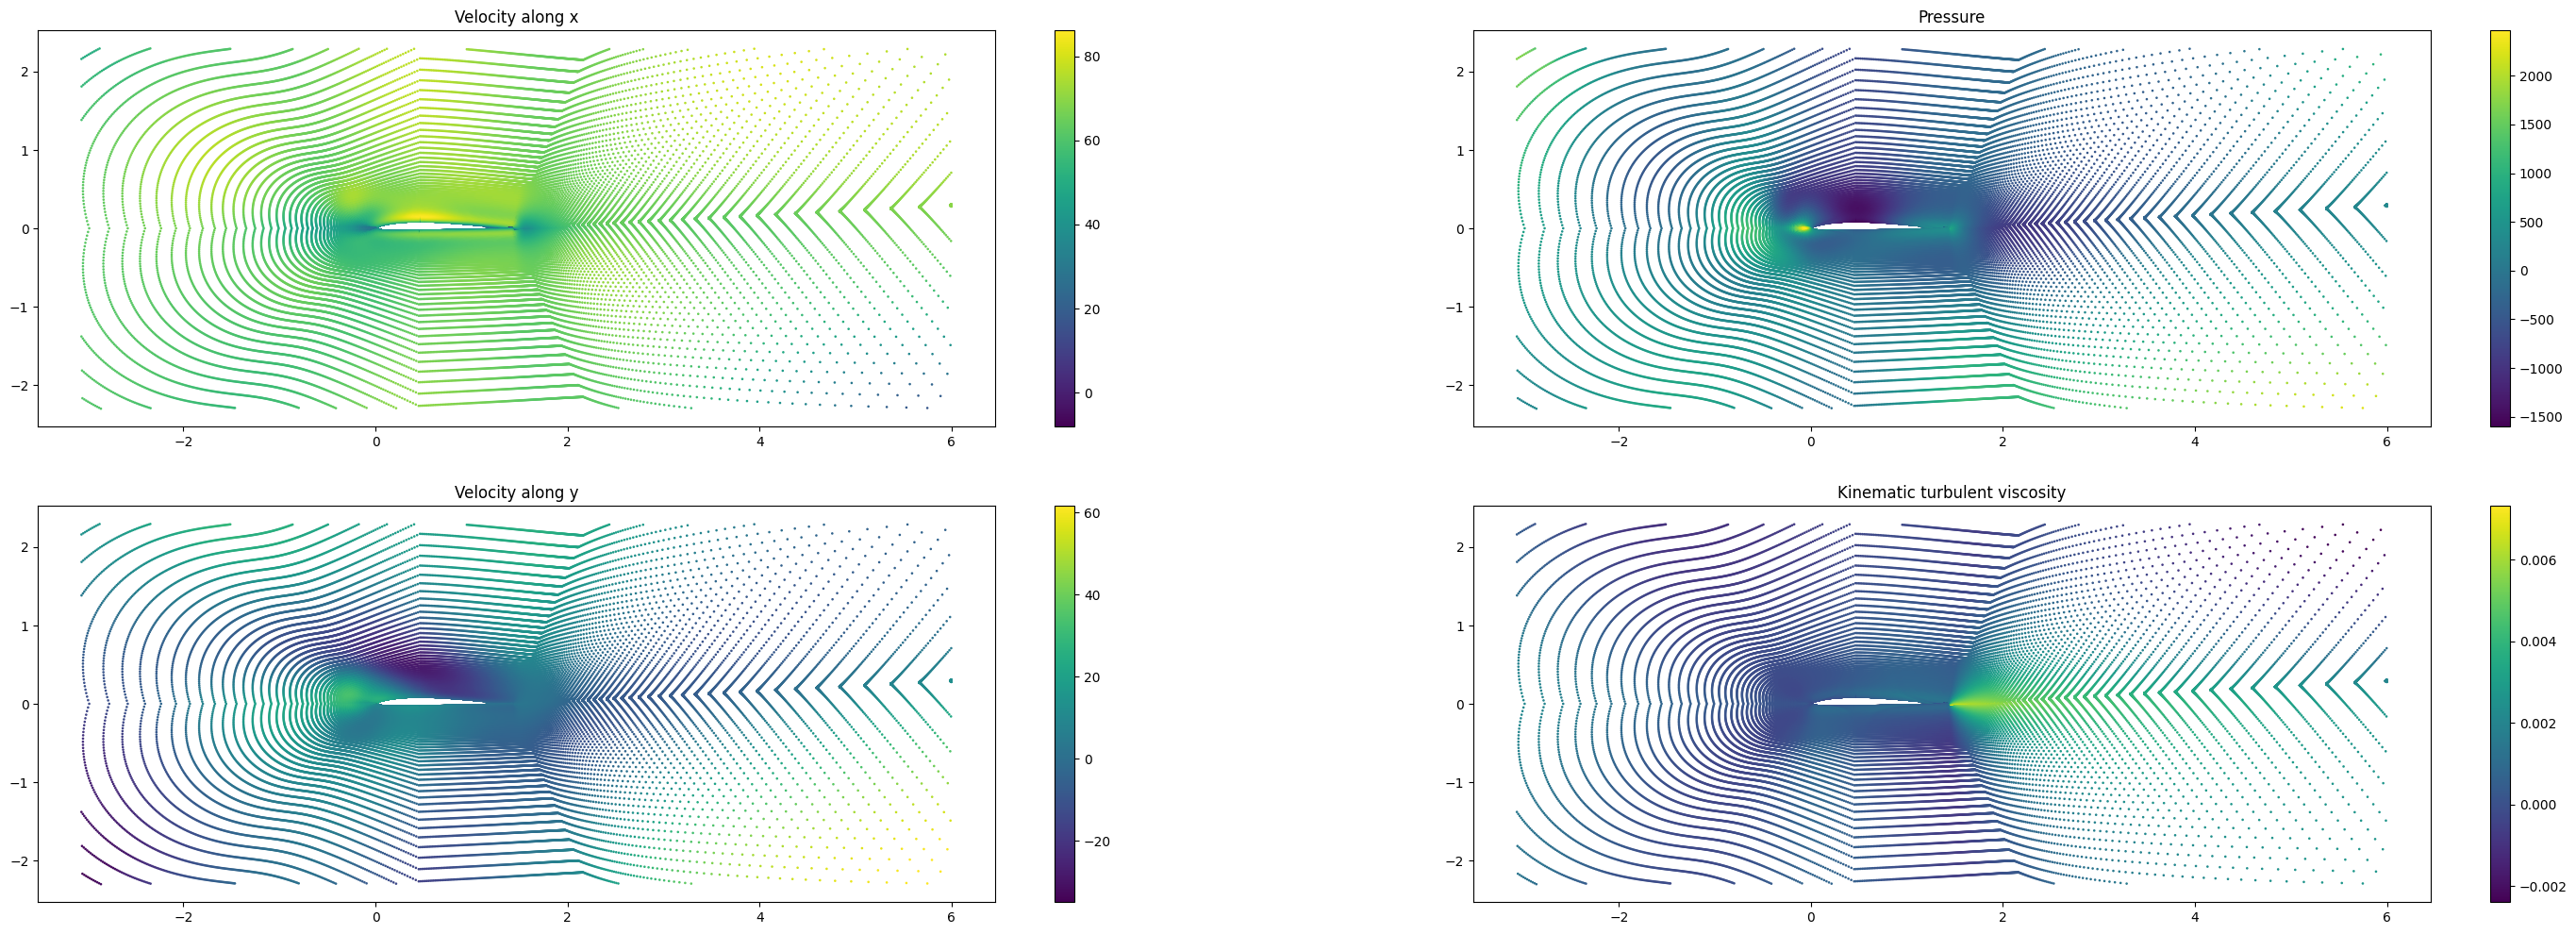

In [ ]:
# x = torch.multiply(sample.x.detach().cpu(), x_scaler).numpy()
x = sample.x.detach().cpu().numpy().copy()
y_true = sample.y.cpu().numpy().copy()
y = out.detach().cpu().numpy().copy()

speed = y[:,0]*STDS['speed'] + MEANS['speed']

pred_y_vel = np.zeros_like(y[:,1])
true_y_vel = np.zeros_like(y[:,1])


pred_x_vel = (np.cos(2*np.pi + y[:,1]))*speed
pred_y_vel[np.where(y[:,1]<=0)] = np.multiply((np.sin(2*np.pi + np.squeeze(y[np.where(y[:,1]<=0),1]))),speed[np.where(y[:,1]<=0)])
pred_y_vel[np.where(y[:,1]>0)] = np.multiply((np.sin(2*np.pi + np.squeeze(y[np.where(y[:,1]>0),1]))),speed[np.where(y[:,1]>0)])

true_x_vel = (np.cos(2*np.pi + y_true[:,1]))*speed
true_y_vel[np.where(y_true[:,1]<=0)] = np.multiply((np.sin(2*np.pi + np.squeeze(y_true[np.where(y_true[:,1]<=0),1]))),speed[np.where(y_true[:,1]<=0)])
true_y_vel[np.where(y_true[:,1]>0)] = np.multiply((np.sin(2*np.pi + np.squeeze(y_true[np.where(y_true[:,1]>0),1]))),speed[np.where(y_true[:,1]>0)])

y[:,0] = pred_x_vel
y[:,1] = pred_y_vel
y[:,2] = (y[:,2]*STDS['pressure']) + MEANS['pressure']
y[:,3] = (y[:,3]*STDS['turbulent_viscosity']) + MEANS['turbulent_viscosity']

y_true[:,0] = true_x_vel
y_true[:,1] = true_y_vel
y_true[:,2] = (y_true[:,2]*STDS['pressure']) + MEANS['pressure']
y_true [:,3] = (y_true[:,3]*STDS['turbulent_viscosity']) + MEANS['turbulent_viscosity']

fig, ax = plt.subplots(2, 2, figsize = (36, 12))
sc0 = ax[0, 0].scatter(x[:, 0], x[:, 1], c = y[:, 0], s = 0.75)
ax[0, 0].title.set_text('Velocity along x')
plt.colorbar(sc0)
sc1 = ax[0, 1].scatter(x[:, 0], x[:, 1], c = y[:, 2], s = 0.75)
ax[0, 1].title.set_text('Pressure')
plt.colorbar(sc1)
sc2 = ax[1, 0].scatter(x[:, 0], x[:, 1], c = y[:, 1], s = 0.75)
ax[1, 0].title.set_text('Velocity along y')
plt.colorbar(sc2)
sc3 = ax[1, 1].scatter(x[:, 0], x[:, 1], c = y[:, 3], s = 0.75)
ax[1, 1].title.set_text('Kinematic turbulent viscosity')
plt.colorbar(sc3)
plt.show()

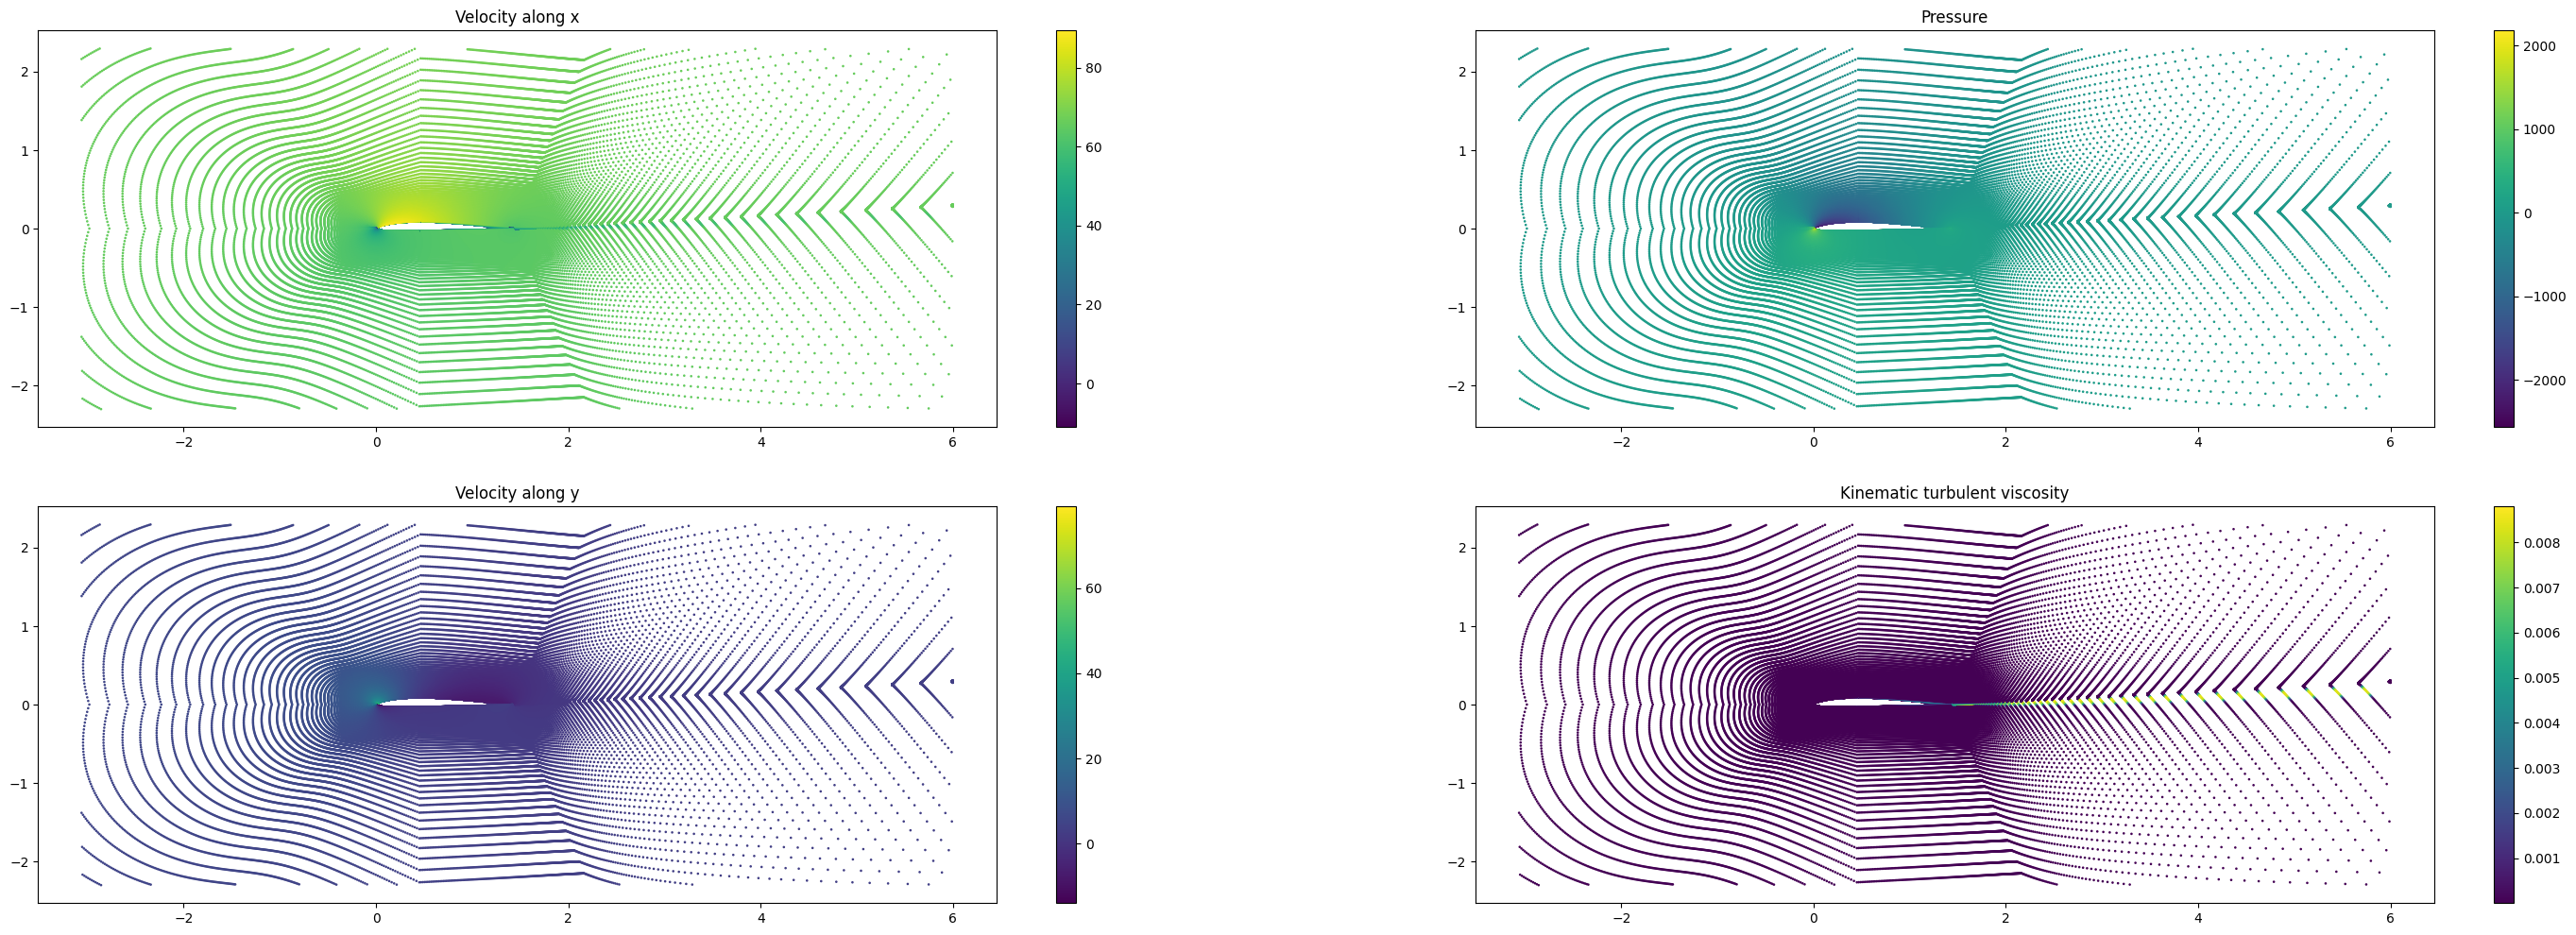

In [ ]:
# x = torch.multiply(sample.x.detach().cpu(), x_scaler).numpy()
y_true = sample.y.cpu().numpy().copy()

speed = y_true[:,0]*STDS['speed'] + MEANS['speed']

true_y_vel = np.zeros_like(y[:,1])

true_x_vel = (np.cos(2*np.pi + y_true[:,1]))*speed
true_y_vel[np.where(y_true[:,1]<=0)] = np.multiply((np.sin(2*np.pi + np.squeeze(y_true[np.where(y_true[:,1]<=0),1]))),speed[np.where(y_true[:,1]<=0)])
true_y_vel[np.where(y_true[:,1]>0)] = np.multiply((np.sin(2*np.pi + np.squeeze(y_true[np.where(y_true[:,1]>0),1]))),speed[np.where(y_true[:,1]>0)])

y_true[:,0] = true_x_vel
y_true[:,1] = true_y_vel
y_true[:,2] = (y_true[:,2]*STDS['pressure']) + MEANS['pressure']
y_true[:,3] = (y_true[:,3]*STDS['turbulent_viscosity']) + MEANS['turbulent_viscosity']

fig, ax = plt.subplots(2, 2, figsize = (36, 12))
sc0 = ax[0, 0].scatter(x[:, 0], x[:, 1], c = y_true[:, 0], s = 0.75)
ax[0, 0].title.set_text('Velocity along x')
plt.colorbar(sc0)
sc1 = ax[0, 1].scatter(x[:, 0], x[:, 1], c = y_true[:, 2], s = 0.75)
ax[0, 1].title.set_text('Pressure')
plt.colorbar(sc1)
sc2 = ax[1, 0].scatter(x[:, 0], x[:, 1], c = y_true[:, 1], s = 0.75)
ax[1, 0].title.set_text('Velocity along y')
plt.colorbar(sc2)
sc3 = ax[1, 1].scatter(x[:, 0], x[:, 1], c = y_true[:, 3], s = 0.75)
ax[1, 1].title.set_text('Kinematic turbulent viscosity')
plt.colorbar(sc3)
plt.show()